# Anac Json Collector
Il seguente flusso, consente di collezionare i dati dal sito dell'anac. 
La sorgente di dati sono in formato aperto, in materia di anticorruzione, trasparenza e contratti pubblici acquisiti dall’ANAC nell’ambito delle proprie attività istituzionali.

I dati sono organizzati in dataset visualizzabili in anteprima in forma tabellare e sono scarcabili in formati aperti e standardizzati JSON e CSV e XML.

Gli anni di riferimento sono 2015,2016, 2017 raggiungibile ai seguenti url:

- http://dati.anticorruzione.it/data/l190-2015.json
- http://dati.anticorruzione.it/data/l190-2016.json
- http://dati.anticorruzione.it/data/l190-2017.json

In [3]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from urllib.request import urlretrieve
from utils.statistics import statistics, optimize_width, bar_chart_simple
from utils.io import get_anac_data

# Matplotlib confs
%matplotlib inline
matplotlib.style.use("seaborn-whitegrid")

Il flusso trasforma il file Json in data frame dei rispettivi anni e successivamente li aggrega in un unico dataframe `df`. 


In [4]:
# Carica i dati 2015, 2016, 2017
df_15 = get_anac_data('data/l190-2015.json', 'http://dati.anticorruzione.it/data/l190-2015.json')
df_16 = get_anac_data('data/l190-2016.json', 'http://dati.anticorruzione.it/data/l190-2016.json')
df_17 = get_anac_data('data/l190-2017.json', 'http://dati.anticorruzione.it/data/l190-2017.json')

# Aggiungi una colonna per la distinzione dell'anno
df_15['anno']='2015'
df_16['anno']='2016'
df_17['anno']='2017'

# Unisci in un unico dataframe
df= df_15.append(df_16).append(df_17)


Il Data frame contiene i seguenti attributi:

- `codice fiscale` rappresentante la partita IVA o codice fiscale della pubblica amministrazione
- `dataUltimoTentativoAccessoUrl`:attributo avente la data dell'ultimo tentativo di comunicazione 
- `esitoUltimoTentativoAccessoUrl`: attributo caratterizzante l'esito della comunicaizone (fallito, successo)
- `identificativoPEC`: attributo rappresentante l'identificativo della pec
- `ragioneSociale`: avente la denominazione dell'ente pubblico
- `url`:  URL comunicato dalla stazione appaltante e punta alla risorsa resa disponibile dalla stessa stazione appaltante presso il proprio sito istituzionale, contenente la specifica degli appalti

Al dataframe orginale sono stati aggiunti i seguenti attributi
- `anno`: attributo che mantiene la suddivisione dei dataframe originali, nel dettaglio se l'istanza appartiene al dataframe del 2015 vedrà il suo attributo anno valorizzato a 2015, analogamente per le istanze dei dataframe 2016 e 2017
- `url2`: attributo contentente gli utlimi 20 caratteri di url
- `ext`: attributo che caratterizza l'extention del file comunicato dalla stazione appaltante.

Di seguito un esempio:

In [5]:
df.head()

,codiceFiscale,dataUltimoTentativoAccessoUrl,esitoUltimoTentativoAccessoUrl,identificativoPEC,ragioneSociale,url,anno
0,80003710789,2015-04-22T18:42:06.137+0000,fallito,opec275.20140526151617.31733.02.1.48@pec.aruba.it,AMMINISTRAZIONE PROVINCIALE DI COSENZA,http://servizi.provincia.cs.it/legge190/2013/i...,2015
1,80015990544,2015-04-22T13:25:54.003+0000,fallito,opec275.20150112133830.12508.04.1.6@pec.actali...,DIREZIONE DIDATTICA DI CORCIANO,http://www.circolodidatticocorciano.gov.it/?pa...,2015
2,84002280547,2015-04-02T15:21:41.117+0000,successo,opec275.20150110123012.28213.03.1.5@pec.actali...,"ISTITUTO COMPRENSIVO ""G.G. PONTANO"" CERRETO DI...",http://omnicomprensivocerretodispoleto.it/avcp...,2015
3,8876071005,2015-03-31T12:32:19.453+0000,successo,opec275.20150112155450.27942.04.1.16@pec.aruba.it,CONSORZIO INVIOLATELLA SALARIA,http://www.consorzioinviolatellasalaria.it/AVC...,2015
4,91011920179,2015-04-22T16:10:28.597+0000,fallito,opec275.20150109120653.25814.06.2.6@pec.actali...,"ISTITUTO ISTRUZIONE SUPERIORE "" C. MARZOLI """,http://www.istitutomarzoli.gov.it/datil190anno...,2015


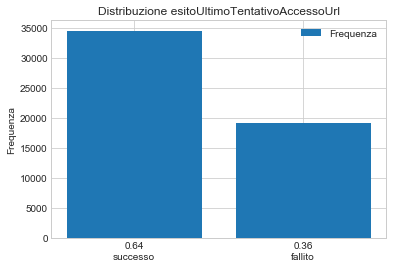

In [6]:
df_stats= statistics(df[['esitoUltimoTentativoAccessoUrl']])
for field in df_stats['Fields']:
    col = df[field].value_counts(dropna=False)
    titolo = "Distribuzione "+str(field)
    bar_chart_simple(col, titolo)

In [7]:
# Per visulizzazione definisci un nuovo campo che sia gli ultimi 20 caratteri di url
df['url2']=df['url'].str[-20:]

# Categorizza: (xml) Se url2 contiene .xml categorizza xml (xls) se url2 cotiene .xls (altro): default
df["ext"] = df["url2"].map(lambda x: "xml" if ".xml" in x else "xls" if ".xls" in x else "altro")

# Scrivi dataframe
df.to_csv('data/l190-collected.csv', sep=';')

**Qual'è la natura delle comunicazioni fallite?** 

In [28]:
# Filtra su fallito
df=df[df['esitoUltimoTentativoAccessoUrl']=='fallito']


In [29]:
# Esegui statistiche di ext
df_stats= statistics(df[['ext']])
df_stats

,Fields,Unique Row,% Unique,N° Missing,% Missing,Field Type,Max,Min,Mean,Var,Kurt
0,ext,3,0.000157,0,0.0,Categorical,0,0,0,0,0


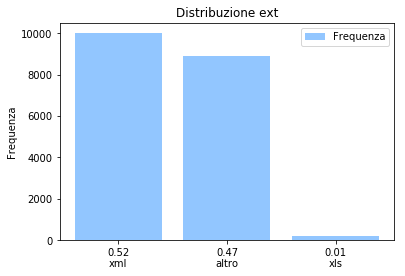

In [30]:
# Plotta     
for field in df_stats['Fields']:
    col = df[field].value_counts(dropna=False)
    titolo = "Distribuzione "+str(field)
    bar_chart_simple(col, titolo)

**Distribuzione dei formati delle sole comunicazione fallite:** una piccola percentuale è caratterizzata da xls, il 47% delle comunicazione fallite sono caratterizzate da xml con schema errato, il 52% delle comunicazioni errate è punta a pagine con una diversa estensione tipicamente pagine web.